# Data Reading

In [ ]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle/30DML_comp

Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle/30DML_comp


In [ ]:
import pandas as pd

raw_test = pd.read_csv("test.csv")
raw_train = pd.read_csv("train.csv")

In [ ]:
raw_train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


# EDA

In [ ]:
raw_train.drop(['id'], inplace = True, axis = 1)

In [ ]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

In [ ]:
def nanCheck(data:pd.DataFrame):
    """Prints all features within a data set and the amount of NaN values in that column."""
    for _ in data.columns:
        print(_, ":", data[_].isnull().sum())

In [ ]:
nanCheck(raw_train)

cat0 : 0
cat1 : 0
cat2 : 0
cat3 : 0
cat4 : 0
cat5 : 0
cat6 : 0
cat7 : 0
cat8 : 0
cat9 : 0
cont0 : 0
cont1 : 0
cont2 : 0
cont3 : 0
cont4 : 0
cont5 : 0
cont6 : 0
cont7 : 0
cont8 : 0
cont9 : 0
cont10 : 0
cont11 : 0
cont12 : 0
cont13 : 0
target : 0


In [ ]:
def correlationCheck(data:pd.DataFrame, label:str):
    """Returns a list of each feature and its correlation to a given label."""
    matrix = data.corr()
    return matrix[label].sort_values(ascending = False)

In [ ]:
correlationCheck(raw_train, 'target')

target    1.000000
cont12    0.055829
cont10    0.052468
cont7     0.035143
cont2     0.034280
cont11    0.033378
cont0     0.028819
cont8     0.017740
cont1    -0.002096
cont6    -0.013807
cont5    -0.015058
cont9    -0.015726
cont3    -0.022759
cont4    -0.023132
cont13   -0.028189
Name: target, dtype: float64

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def corrPlot(data: pd.DataFrame):
  """Shows a correlation matrix plot of a DataFrame's features."""
  f,ax = plt.subplots(figsize = (15,15))
  sns.heatmap(data.corr(), 
              vmin = -1, 
              vmax = 1, 
              annot = True, 
              fmt = '.2g', 
              cmap = 'RdYlGn',
              ax= ax)
  sns.set(font_scale = 0.75)
  plt.xticks(rotation = 45)
  plt.yticks(rotation = 90)
  plt.xlabel('Features', fontsize = 'large')
  return plt.show()

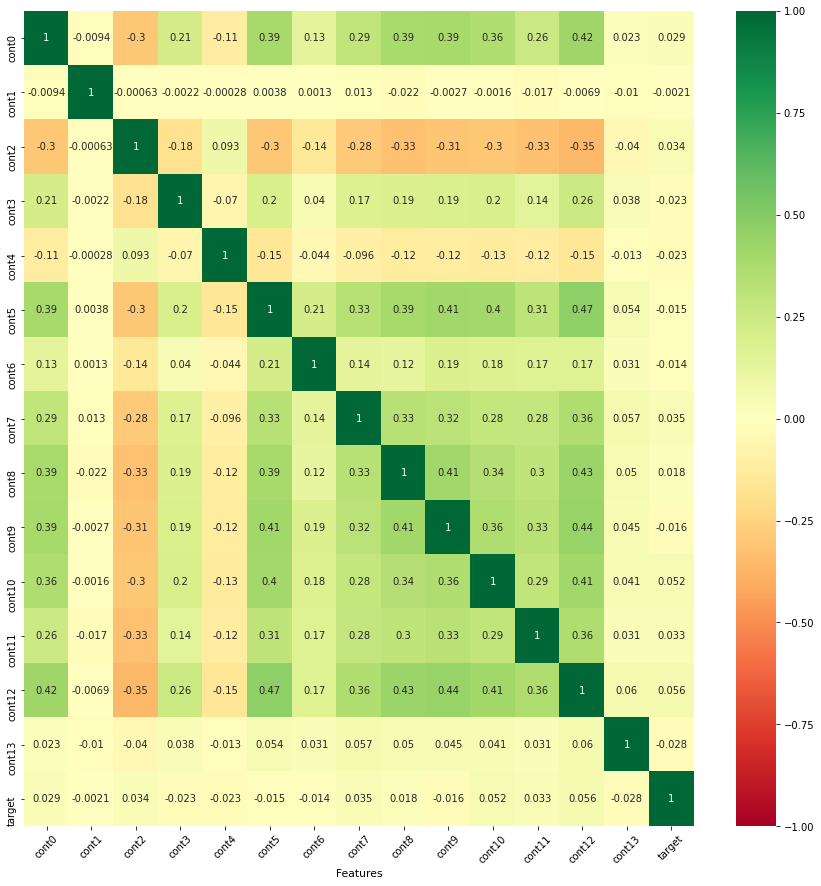

In [ ]:
corrPlot(raw_train)

In [ ]:
def getColNames(data: pd.DataFrame, tpye_str:str) -> list:
  """Returns a list of feature names that match the specified type."""
  temp = (data.dtypes == tpye_str)
  column_names = list(temp[temp].index)
  return column_names

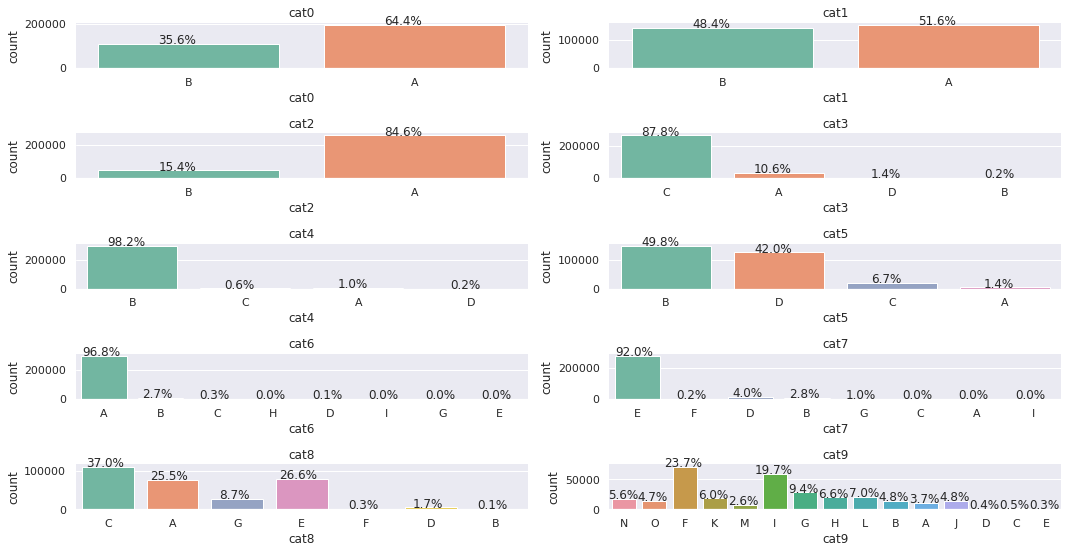

In [ ]:


sns.set_theme(style="white")
sns.set(rc={'figure.figsize':(15,15)})

categoricals = getColNames(raw_train, 'object')

for _, feature in enumerate(categoricals):
                     plt.subplot(len(categoricals),2,_+1)
                    #  plt.set_figheight(15)
                    #  plt.set_figwidth(15)
                     order = raw_train[feature].value_counts(ascending=False).index   
                     sns.set_palette('Set2')
                     ax=sns.countplot(x=raw_train[feature], data=raw_train)
                     sns.despine(top=True,right=True,left=True) # to remove side line from graph

                     for p in ax.patches:
                           percentage = '{:.1f}%'.format(100 * p.get_height()/len(raw_train[feature]))
                           x = p.get_x() + p.get_width() / 2 - 0.05
                           y = p.get_y() + p.get_height()
                           plt.annotate(percentage, (x, y),ha='center')

                     plt.tight_layout()
                     plt.title(feature)

There is an obvious amount of imbalance in this dataset among the categorical variables. To fight against this we will use stratification sampling.

# Data Transformation

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

def ordinallyEncode(data: pd.DataFrame) -> pd.DataFrame:
  """Returns a dataset ordinally encoded from the passed dataset."""
  temp = data.copy()

  ord = OrdinalEncoder()
  objCols = getColNames(temp, 'object')

  temp[objCols] = ord.fit_transform(temp[objCols])

  return temp

In [ ]:
from sklearn.preprocessing import Normalizer

def normalizeData(data: pd.DataFrame) -> pd.DataFrame:
  """Returns a normalized dataset of float64 data feature from the passed dataset."""
  temp = data.copy()

  norm = Normalizer()
  floatCols = getColNames(temp, 'float64')

  temp[floatCols] = norm.fit_transform(temp[floatCols])

  return temp

In [ ]:
train_data = raw_train.copy()
train_data.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [ ]:
target = train_data['target']
target.head()

0    8.113634
1    8.481233
2    8.364351
3    8.049253
4    7.972260
Name: target, dtype: float64

In [ ]:
train_data.drop(columns = ['target'], inplace = True, axis = 1)
train_data.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
1,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
2,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
3,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
4,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


In [ ]:
train_data = normalizeData(train_data)
train_data.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,B,B,B,C,B,B,A,E,C,N,0.128808,-0.009476,0.428167,0.087129,0.390450,0.255968,0.102465,0.198785,0.249004,0.171062,0.151704,0.241590,0.206125,0.556132
1,B,B,A,A,B,D,A,F,A,O,0.324913,0.160654,0.446706,0.159949,0.121056,0.233097,0.244393,0.225754,0.260138,0.149297,0.396162,0.403022,0.114551,0.203362
2,A,A,A,C,B,D,A,D,A,F,0.323137,0.135041,-0.005514,0.251022,0.124030,0.283067,0.163306,0.392688,0.241558,0.367003,0.325791,0.269804,0.235584,0.332333
3,B,B,A,C,B,D,A,E,C,K,0.217536,0.314491,0.292686,0.142109,0.144163,0.338790,0.121067,0.371185,0.344177,0.291117,0.175229,0.361899,0.273547,0.142145
4,A,A,A,C,B,D,A,E,A,N,0.435441,0.151207,-0.021556,0.095625,0.118333,0.282656,0.173086,0.266699,0.281643,0.393637,0.411775,0.319596,0.257510,0.103203


In [ ]:
train_data = ordinallyEncode(train_data)
train_data.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,13.0,0.128808,-0.009476,0.428167,0.087129,0.390450,0.255968,0.102465,0.198785,0.249004,0.171062,0.151704,0.241590,0.206125,0.556132
1,1.0,1.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,14.0,0.324913,0.160654,0.446706,0.159949,0.121056,0.233097,0.244393,0.225754,0.260138,0.149297,0.396162,0.403022,0.114551,0.203362
2,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,5.0,0.323137,0.135041,-0.005514,0.251022,0.124030,0.283067,0.163306,0.392688,0.241558,0.367003,0.325791,0.269804,0.235584,0.332333
3,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,2.0,10.0,0.217536,0.314491,0.292686,0.142109,0.144163,0.338790,0.121067,0.371185,0.344177,0.291117,0.175229,0.361899,0.273547,0.142145
4,0.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0,0.435441,0.151207,-0.021556,0.095625,0.118333,0.282656,0.173086,0.266699,0.281643,0.393637,0.411775,0.319596,0.257510,0.103203


# Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

train_X, valid_X, train_Y, valid_Y = train_test_split(train_data,
                                                    target,
                                                    test_size = 0.2,
                                                    train_size = 0.8,
                                                    shuffle = True,
                                                    random_state = 42) 

# XGBoost Approach


In [ ]:
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

xgb_model = XGBRegressor()

selection = RFE(xgb_model, 50)
selection = selection.fit(train_X, train_Y.values.ravel())
print(selection.support_)
print(selection.ranking_)

[15:24:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
# Finding best number of estimators for an XGBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

possible = [1,5,10,20,50,75,100,250,500]
scores = []


for _ in possible:
  model = XGBRegressor(n_estimators=_)
  model.fit(train_X, train_Y,
            early_stopping_rounds = 5,
            eval_set = [(valid_X, valid_Y)])
  predictions = model.predict(valid_X)
  cv_score = -1 * cross_val_score(model, valid_X, valid_Y,
                  cv = 5,
                  scoring = 'neg_mean_absolute_error')
  scores.append(cv_score.mean())

print("\n", scores)

[15:25:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.00956
Will train until validation_0-rmse hasn't improved in 5 rounds.
[15:25:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-

In [ ]:
target.describe().transpose()

count    300000.000000
mean          8.241979
std           0.746555
min           0.140329
25%           7.742071
50%           8.191373
75%           8.728634
max          10.411992
Name: target, dtype: float64

In [ ]:
target.var()

0.5573440835628073

In [ ]:
# Evaluation of XGBoost

from sklearn.metrics import accuracy_score, precision_score


evaluation_preds = model.predict(valid_X)

acc = accuracy_score(evaluation_preds, valid_Y)
prec = precision_score(evaluation_preds, valid_Y)

print("Accuracy: ", acc)
print("Precision: ", prec)

# LightBGM Approach

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

possible = [1,5,10,20,50,75,100,250,500]
scores = []

for _ in possible:
  print("\n", "Number of estimators: ", _)
  model = LGBMRegressor(n_estimators=_)
  model.fit(train_X, train_Y,
            early_stopping_rounds = 5,
            eval_set = [(valid_X, valid_Y)])
  predictions = model.predict(valid_X)
  cv_score = -1 * cross_val_score(model, valid_X, valid_Y,
                  cv = 5,
                  scoring = 'neg_mean_absolute_error')
  scores.append(cv_score.mean())

print("\n", scores)


 Number of estimators:  1
[1]	valid_0's l2: 0.554465
Training until validation scores don't improve for 5 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid_0's l2: 0.554465

 Number of estimators:  5
[1]	valid_0's l2: 0.554465
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.553154
[3]	valid_0's l2: 0.552007
[4]	valid_0's l2: 0.551026
[5]	valid_0's l2: 0.550197
Did not meet early stopping. Best iteration is:
[5]	valid_0's l2: 0.550197

 Number of estimators:  10
[1]	valid_0's l2: 0.554465
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.553154
[3]	valid_0's l2: 0.552007
[4]	valid_0's l2: 0.551026
[5]	valid_0's l2: 0.550197
[6]	valid_0's l2: 0.549432
[7]	valid_0's l2: 0.548794
[8]	valid_0's l2: 0.548291
[9]	valid_0's l2: 0.547782
[10]	valid_0's l2: 0.547322
Did not meet early stopping. Best iteration is:
[10]	valid_0's l2: 0.547322

 Number of estimators:  20
[1]	valid_0's l2: 0.554465
Training until valida